In [3]:
import pandas as pd

train_raw = pd.read_csv("train_raw.csv")
test_raw  = pd.read_csv("test_raw.csv")

In [4]:
target_col = "Survived"

y_train = train_raw[target_col].copy()
X_train_raw = train_raw.drop(columns=[target_col]).copy()

y_test = test_raw[target_col].copy()
X_test_raw = test_raw.drop(columns=[target_col]).copy()

print("X_train:", X_train_raw.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test_raw.shape)
print("y_test :", y_test.shape)

X_train: (668, 19)
y_train: (668,)
X_test : (223, 19)
y_test : (223,)


In [5]:
X_train_raw = X_train_raw.drop(columns=["title"], errors="ignore")
X_test_raw  = X_test_raw.drop(columns=["title"], errors="ignore")

categorical_cols = [
    "Sex",
    "Embarked",
    "Pclass",
    "title_group",
    "cabin_deck",
    "is_alone",
]

numeric_cols = [c for c in X_train_raw.columns if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numeric_cols)


Categorical columns: ['Sex', 'Embarked', 'Pclass', 'title_group', 'cabin_deck', 'is_alone']
Numerical columns: ['Age', 'SibSp', 'Parch', 'Fare', 'name_length', 'family_size', 'ticket_group_size', 'fare_per_person', 'age_fare_ratio', 'cabin_room_number', 'cabin_score', 'name_word_count']


In [6]:
missing = [c for c in categorical_cols if c not in X_train_raw.columns]
print("Missing categorical columns:", missing)

Missing categorical columns: []


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

dt_clf = DecisionTreeClassifier(random_state=42)

dt_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", dt_clf),
    ]
)


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_cv_scores = cross_val_score(
    dt_pipeline,
    X_train_raw,
    y_train,
    cv=cv,
    scoring="accuracy",
)

print(
    "Decision Tree CV accuracy (mean ± std): "
    f"{dt_cv_scores.mean():.4f} ± {dt_cv_scores.std():.4f}"
)


Decision Tree CV accuracy (mean ± std): 0.7605 ± 0.0170


In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__criterion": ["gini", "entropy"],
    "model__ccp_alpha": [0.0, 0.001, 0.01],
}

dt_grid = GridSearchCV(
    dt_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    refit=True,
)

dt_grid.fit(X_train_raw, y_train)

print("Best params:", dt_grid.best_params_)
print("Best CV accuracy:", f"{dt_grid.best_score_:.4f}")


Best params: {'model__ccp_alpha': 0.01, 'model__criterion': 'entropy', 'model__max_depth': 9, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
Best CV accuracy: 0.8114


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

best_dt = dt_grid.best_estimator_

y_pred_test = best_dt.predict(X_test_raw)

test_acc = accuracy_score(y_test, y_pred_test)
print("Test accuracy:", f"{test_acc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_test))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_test))


Test accuracy: 0.7848

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       137
           1       0.78      0.62      0.69        86

    accuracy                           0.78       223
   macro avg       0.78      0.75      0.76       223
weighted avg       0.78      0.78      0.78       223


Confusion matrix:
[[122  15]
 [ 33  53]]


In [11]:
import pandas as pd
dt_results = pd.DataFrame({
    "model": ["DecisionTree"],
    "cv_mean_accuracy": [dt_grid.best_score_],
    "test_accuracy": [test_acc],
    "best_params": [dt_grid.best_params_]
})
dt_results.head()

,model,cv_mean_accuracy,test_accuracy,best_params
0,DecisionTree,0.811379,0.784753,"{'model__ccp_alpha': 0.01, 'model__criterion':..."


In [12]:
dt_results.to_csv("tables/dt_results.csv", index=False)
dt_results

,model,cv_mean_accuracy,test_accuracy,best_params
0,DecisionTree,0.811379,0.784753,"{'model__ccp_alpha': 0.01, 'model__criterion':..."


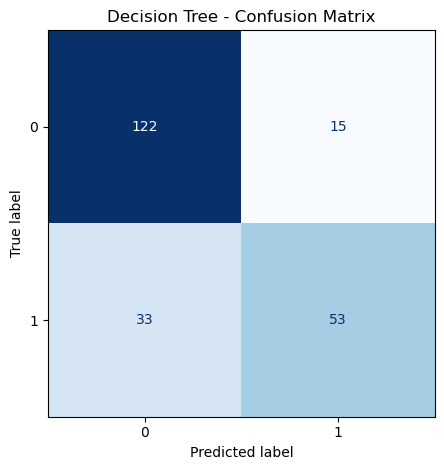

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_dt.classes_)

fig, ax = plt.subplots()
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Decision Tree - Confusion Matrix")
plt.tight_layout()
plt.savefig("plots/dt_confusion_matrix.png")
plt.show()
